# 데이터 살펴보기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

DRIVE_PATH = "/content/drive/MyDrive/" # 내 드라이브의 경로
DATA_DIR_PATH = 'Colab Notebooks'
DATA_FILENAME = "Womens Clothing E-Commerce Reviews.csv" # 디렉토리 내 데이터 파일의 이름
data_path = Path(DRIVE_PATH, DATA_DIR_PATH, DATA_FILENAME)

Mounted at /content/drive


In [4]:
df = pd.read_csv(data_path, index_col=0)

In [5]:
df

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


그래프 테마 설정

In [6]:
sns.set_theme(style='whitegrid', palette='pastel')

점수 분포

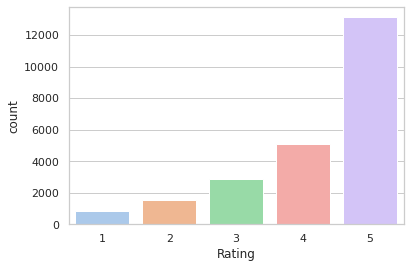

In [7]:
sns.countplot(data=df, x='Rating')
plt.show()

리뷰 길이 분포(글자수)

In [8]:
text_len = df['Review Text'].dropna().map(len)
text_len

0         53
1        303
2        500
3        124
4        192
        ... 
23481    131
23482    223
23483    208
23484    427
23485    110
Name: Review Text, Length: 22641, dtype: int64

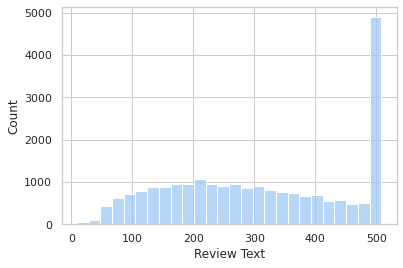

In [9]:
sns.histplot(text_len)
plt.show()

가장 긴 리뷰의 글자수

In [10]:
max(text_len)

508

리뷰 단어수

In [11]:
word_len = df['Review Text'].dropna().map(lambda x: len(x.split()))
word_len

0         8
1        62
2        98
3        22
4        36
         ..
23481    28
23482    38
23483    42
23484    86
23485    19
Name: Review Text, Length: 22641, dtype: int64

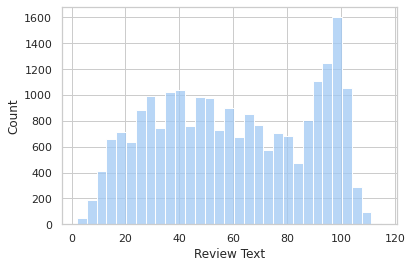

In [12]:
sns.histplot(word_len)
plt.show()

리뷰 길이와 리뷰 투표수

In [13]:
df['Review Words'] = word_len

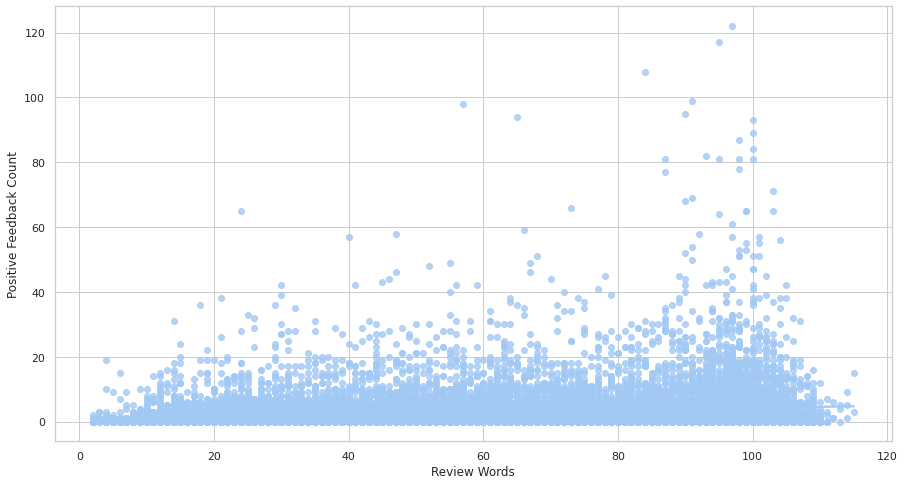

In [14]:
g = sns.regplot(x='Review Words', y='Positive Feedback Count', data=df)
g.figure.set_size_inches(15, 8)
plt.show()

# 텍스트 전처리

In [15]:
df_clean = df.dropna(subset=['Review Text']).copy()

In [16]:
df_clean['Label'] = df_clean['Rating'] == 5

In [17]:
df_clean.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Words,Label
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,8.0,False
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,62.0,True
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,98.0,False
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,22.0,True
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,36.0,True


In [18]:
import spacy
import math
from collections import Counter
from tqdm import tqdm

In [19]:
nlp = spacy.load('en_core_web_sm')

In [20]:
%%time
tokens_normalized = []
for doc in tqdm(nlp.pipe(df_clean['Review Text'].str.lower())):
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    tokens_normalized.append(lemmas)

22641it [02:36, 145.08it/s]

CPU times: user 2min 31s, sys: 4.05 s, total: 2min 35s
Wall time: 2min 36s


In [21]:
from gensim.models.phrases import Phrases, Phraser

In [22]:
%%time
bigram_model = Phrases(tokens_normalized)
bigram_phraser = Phraser(bigram_model)

CPU times: user 4.62 s, sys: 35 ms, total: 4.66 s
Wall time: 4.66 s


In [23]:
tokens_bigram = []
for s in tokens_normalized:
    bigram_phrases = bigram_phraser[s]
    tokens_bigram.append(bigram_phrases)

In [24]:
%%time
trigram_model = Phrases(tokens_bigram)
trigram_phraser = Phraser(trigram_model)

CPU times: user 4.96 s, sys: 38.2 ms, total: 5 s
Wall time: 5 s


In [25]:
%%time
tokens_trigram = []
for s in tokens_bigram:
    trigram_phrases = trigram_phraser[s]
    trigram_phrases = [token for token in trigram_phrases if token not in nlp.Defaults.stop_words and token != '-PRON-']
    tokens_trigram.append(trigram_phrases)

CPU times: user 4.33 s, sys: 50.1 ms, total: 4.38 s
Wall time: 4.38 s


In [26]:
preprocessed_sentences = []
for s in tokens_trigram:
    preprocessed_sentences.append(' '.join(s))

In [27]:
df_clean['Reviews Preprocessed'] = preprocessed_sentences

# 학습용 데이터와 테스트용 데이터 나누기

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
df_train, df_test = train_test_split(df_clean, random_state=0)

# 사전으로 하는 감성분석

Sampled and modified from https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt

긍정 단어는 1, 부정 단어는 -1로 표기한다.

In [30]:
sentiment_vocab = {
    'adorable': 1,
    'adore': 1,
    'allow': 1,
    'amazing': 1,
    'appreciate': 1,
    'attractive': 1,
    'avoid': -1,
    'awesome': 1,
    'awful': -1,
    'awkward': -1,
    'bad': -1,
    'beautiful': 1,
    'beautifully': 1,
    'beauty': 1,
    'best': 1,
    'better': 1,
    'bother': -1,
    'bright': 1,
    'bummer': -1,
    'care': 1,
    'careful': 1,
    'casual': 1,
    'certainly': 1,
    'chance': 1,
    'chic': 1,
    'classy': 1,
    'comfort': 1,
    'comfortable': 1,
    'comfortably': 1,
    'compliment': 1,
    'cool': 1,
    'crazy': -1,
    'create': 1,
    'cut': -1,
    'cute': 1,
    'definitely': 1,
    'difficult': -1,
    'disappoint': -1,
    'disappointed': -1,
    'disappointing': -1,
    'disappointment': -1,
    'dream': 1,
    'easily': 1,
    'easy': 1,
    'elegant': 1,
    'enjoy': 1,
    'excellent': 1,
    'excited': 1,
    'expose': -1,
    'fabulous': 1,
    'fantastic': 1,
    'favorite': 1,
    'feeling': 1,
    'fine': 1,
    'fit': 1,
    'flattering': 1,
    'flirty': 1,
    'forgiving': 1,
    'friend': 1,
    'fun': 1,
    'generous': 1,
    'glad': 1,
    'good': 1,
    'gorgeous': 1,
    'great': 1,
    'hand': 1,
    'happy': 1,
    'hate': -1,
    'help': 1,
    'hesitant': -1,
    'hesitate': -1,
    'hide': -1,
    'holiday': 1,
    'honestly': 1,
    'hope': 1,
    'hopefully': 1,
    'hug': 1,
    'huge': 1,
    'interesting': 1,
    'itchy': -1,
    'justice': 1,
    'lack': -1,
    'like': 1,
    'loose': -1,
    'lose': -1,
    'love': 1,
    'lovely': 1,
    'low': -1,
    'miss': -1,
    'nice': 1,
    'nicely': 1,
    'odd': -1,
    'ok': 1,
    'okay': 1,
    'party': 1,
    'perfect': 1,
    'perfection': 1,
    'perfectly': 1,
    'pleased': 1,
    'pretty': 1,
    'problem': -1,
    'recommend': 1,
    'regret': -1,
    'relaxed': 1,
    'rich': 1,
    'ridiculous': -1,
    'romantic': 1,
    'ruin': -1,
    'sad': -1,
    'sadly': -1,
    'seriously': -1,
    'sexy': 1,
    'solid': 1,
    'special': 1,
    'stop': -1,
    'straight': 1,
    'strange': -1,
    'stunning': 1,
    'substantial': 1,
    'super': 1,
    'support': 1,
    'sure': 1,
    'surprise': 1,
    'surprised': 1,
    'surprisingly': 1,
    'sweet': 1,
    'terrible': -1,
    'thank': 1,
    'thrill': 1,
    'trouble': -1,
    'true': 1,
    'truly': 1,
    'uncomfortable': -1,
    'unfortunately': -1,
    'vibrant': 1,
    'warm': 1,
    'waste': -1,
    'weird': -1,
    'winner': 1,
    'wish': 1,
    'wonderful': 1,
    'wonderfully': 1,
    'worried': -1,
    'worry': -1,
    'worth': 1,
    'wow': 1,
    'wrong': -1,
    'yes': 1
}

In [31]:
def predict_with_dictionary(nermalized_text, sentiment_vocab):
    tokens = nermalized_text.split()
    review_score = 0
    for token in tokens:
        token_score = sentiment_vocab.get(token, 0)
        review_score = review_score + token_score
    review_score = review_score / len(tokens)
    pred = review_score > 0
    return pred

In [32]:
index = 0
print(df_test['Reviews Preprocessed'].iloc[index])
predict_with_dictionary(df_test['Reviews Preprocessed'].iloc[index], sentiment_vocab)

beautiful versatile dress extremely forgiving post_baby_body stylish classy


True

In [33]:
predictictions_with_dict = df_test['Reviews Preprocessed'].map(lambda x: predict_with_dictionary(x, sentiment_vocab))

In [34]:
corrects_with_dict = df_test['Label'] == predictictions_with_dict
corrects_with_dict.sum() / len(corrects_with_dict)

0.5797562268150503

# 토픽으로 하는 감성분석

In [35]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import LdaMulticore

In [36]:
dictionary = Dictionary(tokens_trigram)
dictionary.filter_extremes(no_below=10, no_above=0.4)
dictionary.compactify()

In [37]:
def make_bow_corpus(tokens):
    for review in tokens:
        yield dictionary.doc2bow(review)

In [38]:
corpus_filepath = 'corpus.mm'
MmCorpus.serialize(corpus_filepath, make_bow_corpus(tokens_trigram))
review_corpus = MmCorpus(corpus_filepath)

In [39]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [40]:
%%time
lda = LdaMulticore(review_corpus,
                   num_topics=10,
                   id2word=dictionary,
                   workers=4,
                   random_state=13
                  )

CPU times: user 9.64 s, sys: 910 ms, total: 10.5 s
Wall time: 22.5 s


In [41]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 41.9 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=96974f7fd9da771f4e1fd1e048eeaa91c0c80d88c7ed10ce0261a0db3b7d60e3
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompat

In [42]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [43]:
ldavis = pyLDAvis.gensim_models.prepare(topic_model=lda,
                                       corpus=review_corpus,
                                       dictionary=dictionary)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [44]:
pyLDAvis.display(ldavis)

gensim과 pyLDAvis는 동일한 토픽 인덱스를 공유하지 않는다

In [45]:
lda.show_topic(2)

[('fit', 0.028318198),
 ('dress', 0.01938277),
 ('look', 0.019229079),
 ('like', 0.018901324),
 ('size', 0.016818948),
 ('great', 0.015573374),
 ('wear', 0.014960237),
 ('small', 0.014640876),
 ('love', 0.013938689),
 ('buy', 0.011138214)]

토픽마다 이름을 정해주고 긍부정을 표기해보자

In [46]:
topic_sentiments = {
    0: ('size', -1),
    1: ('dress', 0),
    2: ('size', -1),
    3: ('like', 1),
    4: ('love', 1),
    5: ('fit', 1),
    6: ('size problem', -1),
    7: ('fit', 1),
    8: ('love', 1),
    9: ('great', 1)
}

In [47]:
def preprocess_text(text):
    text = text.lower()
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
    bigrams = bigram_phraser[lemmas]
    trigrams = trigram_phraser[bigrams]
    tokens_normalized = [lemma for lemma in trigrams if lemma not in nlp.Defaults.stop_words and lemma != '-PRON-']
    return tokens_normalized

In [48]:
def get_lda(normalized_text):
    tokens = normalized_text.split()
    bow = dictionary.doc2bow(tokens)
    lda_result = lda[bow]
    return lda_result

In [49]:
def get_sentiment(normalized_text):
    review_lda = get_lda(normalized_text)
    sentiments = [(topic_sentiments[topic][1] * frequency, frequency) for topic, frequency in review_lda]
    
    if not sentiments:
        return 0
    else:
        return sum(senti for senti, freq in sentiments / sum(freq for senti, freq in sentiments))

In [50]:
def describe_review_from_raw(text, min_frequency=0.1):
    tokens = preprocess_text(text)
    normalized_text = ' '.join(tokens)
    review_lda = get_lda(normalized_text)
    sentiment = get_sentiment(normalized_text)
    
    print()
    for topic, frequency in sorted(review_lda, key=lambda x: x[1], reverse=True):
        if frequency < min_frequency:
            continue
        print('{:12}: {}'.format(topic_sentiments[topic][0], round(frequency, 3)))
    
    print('positiveness: {}'.format(sentiment))

In [51]:
def predict_with_lda(normalized_text):
    sentiment = get_sentiment(normalized_text)
    return sentiment >= 0

In [52]:
text = df_train['Review Text'].iloc[0]
print(text)
describe_review_from_raw(text)

I love this shirt, i had my eye on it for awhile but wasn't sure what size i'd be, so i went to the store to try. they only had a small which i figured i would be but it was a little large and not as fitted as i would like it across the chest. i got an xs and it was perfect; i am 5'1 about 120 lbs and a small c cup and it fits great. i love it!!

size        : 0.5170000195503235
great       : 0.45100000500679016
positiveness: -0.06875164830103464


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


정확도 구하기

In [53]:
predictions_with_lda = df_test['Reviews Preprocessed'].map(predict_with_lda)

corrects_with_lda = df_test['Label'] == predictions_with_lda
corrects_with_lda.sum() / len(corrects_with_lda)

0.5490196078431373

# 통계로 하는 감성분석

vectorizer를 초기화 하기

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

In [55]:
vect = CountVectorizer()

사전(vocabulary) 학습하기. document-term matrix를 만드는데 사용됨

In [56]:
vect.fit(df_train['Reviews Preprocessed'])

CountVectorizer()

In [57]:
X_train_dtm = vect.transform(df_train['Reviews Preprocessed'])
X_train_dtm

<16980x11563 sparse matrix of type '<class 'numpy.int64'>'
	with 357673 stored elements in Compressed Sparse Row format>

테스트 데이터를 document-term matrix로 바꾸기(학습된 사전 활용)

In [58]:
X_test_dtm = vect.transform(df_test['Reviews Preprocessed'])
X_test_dtm

<5661x11563 sparse matrix of type '<class 'numpy.int64'>'
	with 116412 stored elements in Compressed Sparse Row format>

Logistic Regression model을 불러오고 초기화

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
logreg = LogisticRegression(max_iter=1000)

X_train_dtm을 이용해 모델 학습

In [61]:
%time logreg.fit(X_train_dtm, df_train['Label'])

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

CPU times: user 2.2 s, sys: 2.84 s, total: 5.05 s
Wall time: 4.08 s


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


LogisticRegression(max_iter=1000)

X_test_dtm에 대해 클래스 예측

In [62]:
y_pred_class = logreg.predict(X_test_dtm)

X_test_dtm에 대해 확률 예측

In [63]:
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]

In [64]:
print(df_test['Review Text'].iloc[0])
print(y_pred_prob[0])

Beautiful and very versatile dress. extremely forgiving for post baby bodies, while stylish and classy.
0.862920658341584


클래스 예측 정확도 구하기

In [65]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [66]:
accuracy_score(df_test['Label'], y_pred_class)

0.773891538597421

# 딥러닝으로 하는 감성분석

미리 학습된 딥러닝 모델을 불러와 파인튜닝(fine-tuning)을 통해 텍스트 분류를 해보자

허깅페이스의 transformers 라이브러리를 활용한다.

https://huggingface.co/docs/transformers/index

In [67]:
!pip install transformers datasets

     |████████████████████████████████| 3.5 MB 4.9 MB/s 
     |████████████████████████████████| 311 kB 36.2 MB/s 
     |████████████████████████████████| 895 kB 34.3 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 596 kB 40.8 MB/s 
     |████████████████████████████████| 6.8 MB 35.2 MB/s 
     |████████████████████████████████| 133 kB 8.5 MB/s 
     |████████████████████████████████| 243 kB 20.8 MB/s 
     |████████████████████████████████| 1.1 MB 33.0 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 
     |████████████████████████████████| 271 kB 8.3 MB/s 
     |████████████████████████████████| 144 kB 39.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [68]:
from transformers import AutoTokenizer

In [69]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

In [70]:
print(df_train['Review Text'].loc[0])

Absolutely wonderful - silky and sexy and comfortable


In [71]:
tokenizer(df_train['Review Text'].loc[0], padding='max_length', truncation=True)

{'input_ids': [101, 108394, 10454, 11367, 11304, 14446, 118, 33694, 11445, 10111, 18549, 10157, 10111, 10212, 81587, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [72]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

dataset 라이브러리를 불러온다.<br>
허깅페이스에서 개발한 자연어 등 여러 데이터셋을 다루기 위한 라이브러리이다.

In [73]:
from datasets import Dataset

리뷰 텍스트와 레이블 데이터셋을 만든다

In [74]:
dataset_train = Dataset.from_dict({'text': df_train['Review Text'], 'label': df_train['Label']})
dataset_test = Dataset.from_dict({'text': df_test['Review Text'], 'label': df_test['Label']})

dataset의 map 함수를 이용해 토크나이징 함수를 적용한다

In [75]:
dataset_train_tokenized = dataset_train.map(tokenize_function, batched=True)
dataset_test_tokenized = dataset_test.map(tokenize_function, batched=True)

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

모델을 불러온다.<br>
분류용으로 불러오며, 분류하는 레이블은 2개이다.

In [76]:
from transformers import AutoModelForSequenceClassification

In [77]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [78]:
from transformers import TrainingArguments

디렉토리(runs)에 학습된 모델이 저장된다

In [79]:
training_args = TrainingArguments('runs', num_train_epochs=1)

In [80]:
x = np.array([[5, 4, 3], [7, 10, 9]])
index_array = np.argmax(x, axis=-1)
index_array

array([0, 1])

In [81]:
import numpy as np
from datasets import load_metric

metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

In [82]:
from transformers import Trainer

In [83]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train_tokenized,
    eval_dataset=dataset_test_tokenized,
    compute_metrics=compute_metrics
)

학습을 진행한다.

In [84]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 16980
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2123


Step,Training Loss
500,0.672600
1000,0.633300
1500,0.533100
2000,0.490800


Saving model checkpoint to runs/checkpoint-500
Configuration saved in runs/checkpoint-500/config.json
Model weights saved in runs/checkpoint-500/pytorch_model.bin
Saving model checkpoint to runs/checkpoint-1000
Configuration saved in runs/checkpoint-1000/config.json
Model weights saved in runs/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to runs/checkpoint-1500
Configuration saved in runs/checkpoint-1500/config.json
Model weights saved in runs/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to runs/checkpoint-2000
Configuration saved in runs/checkpoint-2000/config.json
Model weights saved in runs/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2123, training_loss=0.5751818253979388, metrics={'train_runtime': 4111.7485, 'train_samples_per_second': 4.13, 'train_steps_per_second': 0.516, 'total_flos': 4467625720012800.0, 'train_loss': 0.5751818253979388, 'epoch': 1.0})

학습이 끝난 모델을 평가한다

In [85]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 5661
  Batch size = 8


{'epoch': 1.0,
 'eval_accuracy': 0.7846670199611376,
 'eval_loss': 0.47675976157188416,
 'eval_runtime': 483.4726,
 'eval_samples_per_second': 11.709,
 'eval_steps_per_second': 1.464}

정확도 78%

In [86]:
def predict_with_bert(text):
    inputs = tokenizer(text, return_tensors='pt')
    inputs = inputs.to(model.device)
    outputs = model(**inputs)
    prediction = outputs['logits'].argmax().item()
    return prediction > 0

In [87]:
text = df_test['Review Text'].iloc[0]
print(text)
print(predict_with_bert(text))

Beautiful and very versatile dress. extremely forgiving for post baby bodies, while stylish and classy.
True
